In [1]:
from models.VLAE import VLAE
vlae_fm1 = VLAE(input_dim=(28,28,1),
                inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                gen2_num_units=[1024, 1024],
                gen1_num_units=[1024, 1024],
                gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
                use_dropout=False, use_batch_norm=False, log_dir="ok", kernel_visualization_layer=1, num_samples=5,
                feature_map_layers=[1], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=1,
                z_dims=[2,2,2])
vlae_fm1.load_weights("/Users/leo/Documents/Tesla3/small-vae/master-thesis-leonard/logs_vlae_28_mnist_reduced_1fms_06-06-2020/")


Using TensorFlow backend.


100%|██████████| 3/3 [00:00<00:00, 23.35it/s]


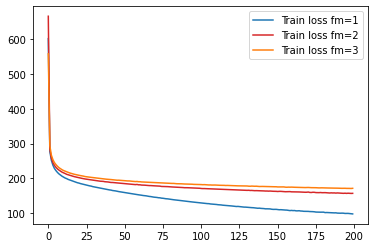

25
38
51


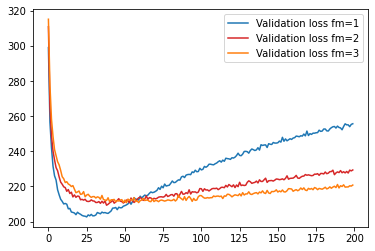

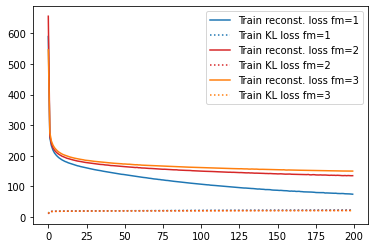

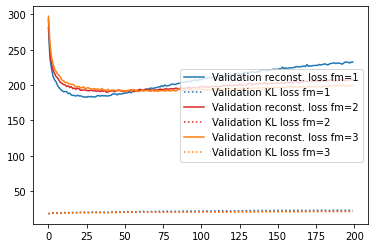

In [2]:


import os,csv
from tqdm import trange
import numpy as np
# val_loss: 2
# val_vae_r_loss: 3
# val_vae_kl_loss: 4
# loss: 5
# vae_r_loss: 6
# vae_kl_loss: 7

from matplotlib import pyplot as plt

colors = ['tab:blue', 'tab:red', 'tab:orange']

for fm in trange(1,4):
    epoch = []
    val_loss = []
    val_vae_r_loss = []
    val_vae_kl_loss = []
    loss = []
    vae_r_loss = []
    vae_kl_loss = []
    color = colors[fm-1]
    with open(os.path.join('/Users/leo/Documents/Tesla3/small-vae/master-thesis-leonard/logs_vlae_28_mnist_reduced_{}fms_06-06-2020/losses_epoch.csv'.format(fm)), newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar="'")
        for i, row in enumerate(spamreader):
            if i == 0:
                continue
            epoch.append(float(row[1]))
            val_loss.append(float(row[2]))
            val_vae_r_loss.append(float(row[3]))
            val_vae_kl_loss.append(float(row[4]))
            loss.append(float(row[5]))
            vae_r_loss.append(float(row[6]))
            vae_kl_loss.append(float(row[7]))
    plt.plot(list(range(len(loss))), loss, color=color, label="Train loss fm={}".format(fm))
plt.legend()
plt.show()

for fm in trange(1,4):
    epoch = []
    val_loss = []
    val_vae_r_loss = []
    val_vae_kl_loss = []
    loss = []
    vae_r_loss = []
    vae_kl_loss = []
    color = colors[fm-1]
    with open(os.path.join('/Users/leo/Documents/Tesla3/small-vae/master-thesis-leonard/logs_vlae_28_mnist_reduced_{}fms_06-06-2020/losses_epoch.csv'.format(fm)), newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar="'")
        for i, row in enumerate(spamreader):
            if i == 0:
                continue
            epoch.append(float(row[1]))
            val_loss.append(float(row[2]))
            val_vae_r_loss.append(float(row[3]))
            val_vae_kl_loss.append(float(row[4]))
            loss.append(float(row[5]))
            vae_r_loss.append(float(row[6]))
            vae_kl_loss.append(float(row[7]))
    plt.plot(list(range(len(val_loss))), val_loss, color=color, label="Validation loss fm={}".format(fm))
    print(np.argmin(val_loss))
plt.legend()
plt.show()

for fm in trange(1,4):
    epoch = []
    val_loss = []
    val_vae_r_loss = []
    val_vae_kl_loss = []
    loss = []
    vae_r_loss = []
    vae_kl_loss = []
    color = colors[fm-1]
    with open(os.path.join('/Users/leo/Documents/Tesla3/small-vae/master-thesis-leonard/logs_vlae_28_mnist_reduced_{}fms_06-06-2020/losses_epoch.csv'.format(fm)), newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar="'")
        for i, row in enumerate(spamreader):
            if i == 0:
                continue
            epoch.append(float(row[1]))
            val_loss.append(float(row[2]))
            val_vae_r_loss.append(float(row[3]))
            val_vae_kl_loss.append(float(row[4]))
            loss.append(float(row[5]))
            vae_r_loss.append(float(row[6]))
            vae_kl_loss.append(float(row[7]))
    plt.plot(list(range(len(val_loss))), vae_r_loss, color=color, label="Train reconst. loss fm={}".format(fm))
    plt.plot(list(range(len(val_loss))), vae_kl_loss, color=color, linestyle='dotted', label="Train KL loss fm={}".format(fm))
plt.legend()
plt.show()

for fm in trange(1,4):
    epoch = []
    val_loss = []
    val_vae_r_loss = []
    val_vae_kl_loss = []
    loss = []
    vae_r_loss = []
    vae_kl_loss = []
    color = colors[fm-1]
    with open(os.path.join('/Users/leo/Documents/Tesla3/small-vae/master-thesis-leonard/logs_vlae_28_mnist_reduced_{}fms_06-06-2020/losses_epoch.csv'.format(fm)), newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar="'")
        for i, row in enumerate(spamreader):
            if i == 0:
                continue
            epoch.append(float(row[1]))
            val_loss.append(float(row[2]))
            val_vae_r_loss.append(float(row[3]))
            val_vae_kl_loss.append(float(row[4]))
            loss.append(float(row[5]))
            vae_r_loss.append(float(row[6]))
            vae_kl_loss.append(float(row[7]))
    plt.plot(list(range(len(val_loss))), val_vae_r_loss, color=color, label="Validation reconst. loss fm={}".format(fm))
    plt.plot(list(range(len(val_loss))), val_vae_kl_loss, color=color, linestyle='dotted', label="Validation KL loss fm={}".format(fm))
plt.legend()
plt.show()